In [1]:
import openai
import pandas as pd
import numpy as np
from openai.embeddings_utils import get_embedding, cosine_similarity
import API_Key
openai.api_key  = API_Key.Openai_Key


### Important Models and their usecases:

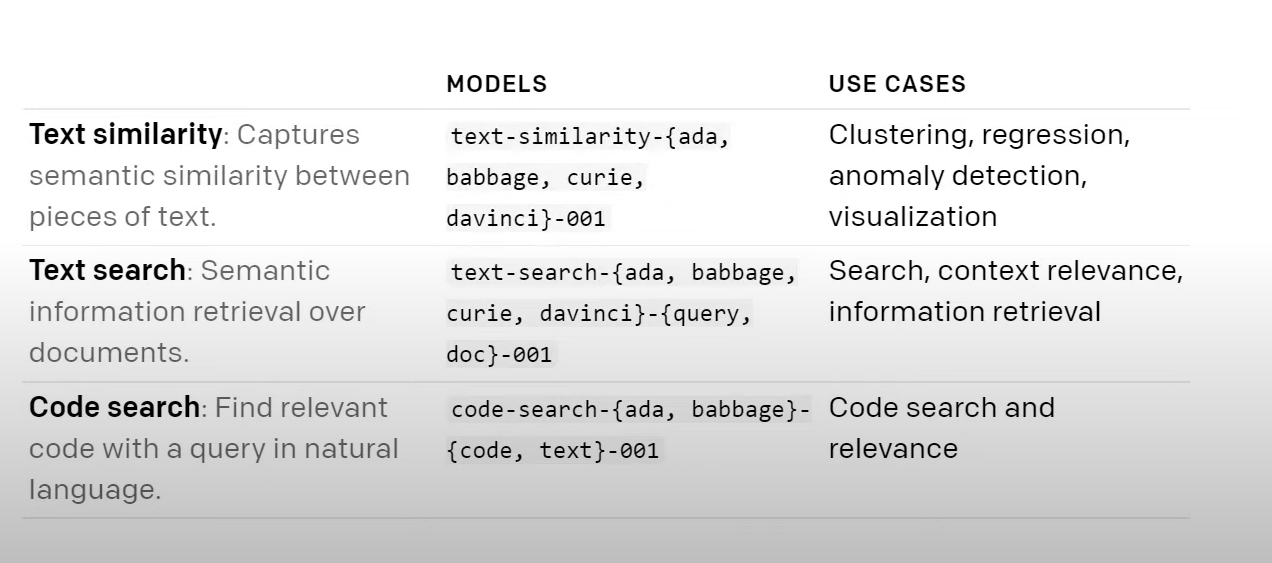

### Text Similarity

In [2]:
resp = openai.Embedding.create(
    input = ['eating food', 'I am hungry', 'I am travelling', 'exploring new places'],
    engine = 'text-similarity-davinci-001'
)

In [3]:
type(resp['data'])

list

In [ ]:
resp['data']

In [4]:
type(resp['data'][0])

openai.openai_object.OpenAIObject

In [5]:

len(resp['data'])

4

In [6]:
resp['data'][0].keys()

dict_keys(['object', 'index', 'embedding'])

In [ ]:
resp['data'][0]['embedding']

In [7]:
embedding_a = resp['data'][0]['embedding']
embedding_b = resp['data'][1]['embedding']
embedding_c = resp['data'][2]['embedding']
embedding_d = resp['data'][3]['embedding']

In [8]:

np.dot(embedding_a, embedding_b)

0.872262739242016

In [9]:
np.dot(embedding_a, embedding_c)

0.7880975199341193

In [10]:
np.dot(embedding_c, embedding_d)

0.8505553638635099

In [11]:
# https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
datafile_path = "https://cdn.openai.com/API/examples/data/fine_food_reviews_with_embeddings_1k.csv" 
df = pd.read_csv(datafile_path)
df.head()
     

,ProductId,UserId,Score,Summary,Text,combined,n_tokens,babbage_similarity,babbage_search
0,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,51,"[-0.01274053193628788, 0.010849879123270512, -...","[-0.01880764216184616, 0.019457539543509483, -..."
1,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...,35,"[-0.024154752492904663, 0.0024838377721607685,...","[-0.03571609780192375, 0.010356518439948559, -..."
2,B000JMBE7M,AQX1N6A51QOKG,4,"It isn't blanc mange, but isn't bad . . .",I'm not sure that custard is really custard wi...,"Title: It isn't blanc mange, but isn't bad . ....",277,"[0.0032693513203412294, 0.017815979197621346, ...","[-0.010433986783027649, 0.024620095267891884, ..."
3,B004AHGBX4,A2UY46X0OSNVUQ,3,These also have SALT and it's not sea salt.,I like the fact that you can see what you're g...,Title: These also have SALT and it's not sea s...,246,"[-0.03584608808159828, 0.03424076735973358, -0...","[-0.040209852159023285, 0.03804996609687805, -..."
4,B001BORBHO,A1AFOYZ9HSM2CZ,5,Happy with the product,My dog was suffering with itchy skin. He had ...,Title: Happy with the product; Content: My dog...,87,"[0.005218076519668102, 0.018165964633226395, -...","[0.010450801812112331, 0.022801749408245087, -..."


In [ ]:
type(df.loc[0]['babbage_search'])

In [12]:

df["babbage_search"] = df.babbage_search.apply(eval).apply(np.array)
df["babbage_similarity"] = df.babbage_similarity.apply(eval).apply(np.array)

In [13]:
type(df.loc[0]['babbage_search'])

numpy.ndarray

### Semantic Search

In [14]:
# search through the reviews for a specific product
def search_reviews(df, search_query, n=3):
    embedding = get_embedding(
        search_query,
        engine="text-search-babbage-query-001"
    )
    df["similarities"] = df.babbage_search.apply(lambda x: cosine_similarity(x, embedding))

    top_n =df.sort_values("similarities", ascending=False).head(n)
    # res = top_n.combined.str.replace("Title: ", "").str.replace("; Content:", ": ")
    return top_n

In [15]:
res = search_reviews(df, "delicious beans", n=3)
res['combined'].to_list()
     

['Title: Fantastic Instant Refried beans; Content: Fantastic Instant Refried Beans have been a staple for my family now for nearly 20 years.  All 7 of us love it and my grown kids are passing on the tradition.',
 'Title: Jamaican Blue beans; Content: Excellent coffee bean for roasting. Our family just purchased another 5 pounds for more roasting. Plenty of flavor and mild on acidity when roasted to a dark brown bean and before any oil appears on the bean itself (455F @ 17 minutes).',
 "Title: Delicious!; Content: I enjoy this white beans seasoning, it gives a rich flavor to the beans I just love it, my mother in law didn't know about this Zatarain's brand and now she is traying different seasoning and she likes it very much.<br />Thank you Amazon for having it because now I can't find it in stores, I like to have this 12 boxes because I can made it whenever my family want it."]

### Classification

In [16]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    list(df.babbage_similarity.values),
    df.Score,
    test_size = 0.2,
    random_state=42
)

In [17]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
 
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

In [18]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           1       0.59      0.72      0.65        18
           2       1.00      0.35      0.52        17
           3       0.50      0.12      0.20         8
           4       0.83      0.38      0.53        26
           5       0.82      0.99      0.90       131

    accuracy                           0.80       200
   macro avg       0.75      0.52      0.56       200
weighted avg       0.81      0.80      0.77       200



In [19]:
len(df)     

1000

In [20]:
df['Score'].value_counts(normalize=True)

Score
5    0.651
4    0.138
1    0.087
3    0.075
2    0.049
Name: proportion, dtype: float64

### Clustering

In [24]:
# source: https://stackoverflow.com/questions/55619176/how-to-cluster-similar-sentences-using-bert

from sklearn.cluster import KMeans

corpus = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'Horse is eating grass.',
          'A man is eating pasta.',
          'A Woman is eating Biryani.',
          'The girl is carrying a baby.',
          'The baby is carried by the woman',
          'A man is riding a horse.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'Someone in a gorilla costume is playing a set of drums.',
          'A cheetah is running behind its prey.',
          'A cheetah chases prey on across a field.',
          'The cheetah is chasing a man who is riding the horse.',
          'man and women with their baby are watching cheetah in zoo'
          ]

In [25]:
response = openai.Embedding.create(
    input=corpus,
    model="text-similarity-babbage-001"
)

In [26]:
type(response['data'])

list

In [ ]:
response['data'][0]['embedding']

In [27]:
corpus_embeddings = [ d['embedding'] for d in response['data']]

In [28]:
# Normalize the embeddings to unit length
corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

In [29]:
clustering_model = KMeans(n_clusters=3)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_
print(cluster_assignment)

c:\Users\igyan\anaconda3\envs\training_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[1 1 1 1 1 0 0 2 2 0 0 2 2 2 2]


In [30]:
clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []

    clustered_sentences[cluster_id].append(corpus[sentence_id])
clustered_sentences

{1: ['A man is eating food.',
  'A man is eating a piece of bread.',
  'Horse is eating grass.',
  'A man is eating pasta.',
  'A Woman is eating Biryani.'],
 0: ['The girl is carrying a baby.',
  'The baby is carried by the woman',
  'A monkey is playing drums.',
  'Someone in a gorilla costume is playing a set of drums.'],
 2: ['A man is riding a horse.',
  'A man is riding a white horse on an enclosed ground.',
  'A cheetah is running behind its prey.',
  'A cheetah chases prey on across a field.',
  'The cheetah is chasing a man who is riding the horse.',
  'man and women with their baby are watching cheetah in zoo']}

In [31]:
clustering_model = KMeans(n_clusters=4)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_
print(cluster_assignment)

[0 0 0 0 0 3 3 0 2 1 1 2 2 2 2]


c:\Users\igyan\anaconda3\envs\training_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [32]:
clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []

    clustered_sentences[cluster_id].append(corpus[sentence_id])
clustered_sentences

{0: ['A man is eating food.',
  'A man is eating a piece of bread.',
  'Horse is eating grass.',
  'A man is eating pasta.',
  'A Woman is eating Biryani.',
  'A man is riding a horse.'],
 3: ['The girl is carrying a baby.', 'The baby is carried by the woman'],
 2: ['A man is riding a white horse on an enclosed ground.',
  'A cheetah is running behind its prey.',
  'A cheetah chases prey on across a field.',
  'The cheetah is chasing a man who is riding the horse.',
  'man and women with their baby are watching cheetah in zoo'],
 1: ['A monkey is playing drums.',
  'Someone in a gorilla costume is playing a set of drums.']}